In [1]:
import tensorflow as tf
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [3]:
import tensorflow as tf
import numpy as np
import time


# ---------- Custom Initializers ----------
class XavierInit(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        in_dim, out_dim = shape
        std = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.random.normal(shape, stddev=std, dtype=dtype)


class NTKInit(tf.keras.initializers.Initializer):
    def __call__(self, shape, dtype=None):
        in_dim, out_dim = shape
        std = 1. / np.sqrt(in_dim)
        return tf.random.normal(shape, stddev=std, dtype=dtype)


# ---------- PINN Model ----------
class PINN(tf.keras.Model):
    def __init__(self, layers, X_u, Y_u, X_r, Y_r, init="ntk"):
        super(PINN, self).__init__()

        # Normalization
        self.mu_X, self.sigma_X = X_r.mean(0), X_r.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]

        self.X_u = (X_u - self.mu_X) / self.sigma_X
        self.Y_u = Y_u
        self.X_r = (X_r - self.mu_X) / self.sigma_X
        self.Y_r = Y_r

        # Initializer choice
        if init.lower() == "xavier":
            kernel_init = XavierInit()
        elif init.lower() == "ntk":
            kernel_init = NTKInit()
        else:
            kernel_init = "glorot_normal"

        # Build NN layers
        self.layers_ = []
        for i in range(len(layers) - 2):
            self.layers_.append(
                tf.keras.layers.Dense(
                    layers[i+1],
                    activation=tf.nn.tanh,
                    kernel_initializer=kernel_init
                )
            )
        self.out_layer = tf.keras.layers.Dense(layers[-1], activation=None,
                                               kernel_initializer=kernel_init)

        # Logs
        self.loss_bcs_log, self.loss_res_log = [], []
        self.K_uu_log, self.K_rr_log, self.K_ur_log = [], [], []
        self.weights_log, self.biases_log = [], []

    # Forward pass
    def call(self, X):
        H = X
        for l in self.layers_:
            H = l(H)
        return self.out_layer(H)

    # PDE solution u(x)
    def net_u(self, x):
        return self.call(x)

    # PDE residual r(x)
    def net_r(self, x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            with tf.GradientTape() as tape1:
                tape1.watch(x)
                u = self.net_u(x)
            u_x = tape1.gradient(u, x) / self.sigma_x
        u_xx = tape2.gradient(u_x, x) / self.sigma_x
        return u_xx

    # Loss function
    def loss_fn(self, X_u, Y_u, X_r, Y_r):
        X_u = tf.convert_to_tensor(X_u, dtype=tf.float32)
        Y_u = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        X_r = tf.convert_to_tensor(X_r, dtype=tf.float32)
        Y_r = tf.convert_to_tensor(Y_r, dtype=tf.float32)

        u_pred = self.net_u(X_u)
        r_pred = self.net_r(X_r)

        loss_bcs = tf.reduce_mean(tf.square(u_pred - Y_u))
        loss_res = tf.reduce_mean(tf.square(r_pred - Y_r))
        loss = loss_bcs + loss_res
        return loss, loss_bcs, loss_res

    # ---------- NTK Utilities ----------
    def compute_jacobian(self, X):
        """Jacobian of outputs wrt. params"""
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        with tf.GradientTape(persistent=True) as tape:
            u = self.net_u(X)
        J_list = []
        for p in self.trainable_variables:
            grad_p = tape.jacobian(u, p)   # [N, ...]
            grad_p = tf.reshape(grad_p, [u.shape[0], -1])
            J_list.append(grad_p)
        del tape
        return tf.concat(J_list, axis=1)  # [N, num_params]

    def compute_ntk(self, X1, X2):
        J1 = self.compute_jacobian(X1)
        J2 = self.compute_jacobian(X2)
        return tf.matmul(J1, J2, transpose_b=True)

    # ---------- Training Loop ----------
    def train(self, nIter=10000, lr=1e-3, log_NTK=False, log_weights=False):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        start_time = time.time()

        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss, loss_bcs, loss_res = self.loss_fn(
                    self.X_u, self.Y_u, self.X_r, self.Y_r
                )
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))

            if it % 100 == 0:
                elapsed = time.time() - start_time
                print(f"It: {it}, Loss: {loss.numpy():.3e}, "
                      f"Loss_bcs: {loss_bcs.numpy():.3e}, "
                      f"Loss_res: {loss_res.numpy():.3e}, Time: {elapsed:.2f}")
                self.loss_bcs_log.append(loss_bcs.numpy())
                self.loss_res_log.append(loss_res.numpy())
                start_time = time.time()

                # Log weights/biases
                if log_weights:
                    weights = [v.numpy() for v in self.trainable_variables if "kernel" in v.name]
                    biases = [v.numpy() for v in self.trainable_variables if "bias" in v.name]
                    self.weights_log.append(weights)
                    self.biases_log.append(biases)

                # Log NTK
                if log_NTK:
                    K_uu = self.compute_ntk(self.X_u, self.X_u).numpy()
                    K_rr = self.compute_ntk(self.X_r, self.X_r).numpy()
                    K_ur = self.compute_ntk(self.X_u, self.X_r).numpy()
                    self.K_uu_log.append(K_uu)
                    self.K_rr_log.append(K_rr)
                    self.K_ur_log.append(K_ur)

    # ---------- Predictions ----------
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        return self.net_u(tf.convert_to_tensor(X_star, dtype=tf.float32)).numpy()

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        return self.net_r(tf.convert_to_tensor(X_star, dtype=tf.float32)).numpy()


In [4]:
# Define solution and its Laplace
a = 4

def u(x, a):
  return np.sin(np.pi * a * x)

def u_xx(x, a):
  return -(np.pi * a)**2 * np.sin(np.pi * a * x)

In [5]:
# Define computional domain
bc1_coords = np.array([[0.0],
                       [0.0]])

bc2_coords = np.array([[1.0],
                       [1.0]])

dom_coords = np.array([[0.0],
                       [1.0]])

# Training data on u(x) -- Dirichlet boundary conditions

nn  = 100

X_bc1 = dom_coords[0, 0] * np.ones((nn // 2, 1))
X_bc2 = dom_coords[1, 0] * np.ones((nn // 2, 1))
X_u = np.vstack([X_bc1, X_bc2])
Y_u = u(X_u, a)

X_r = np.linspace(dom_coords[0, 0],
                  dom_coords[1, 0], nn)[:, None]
Y_r = u_xx(X_r, a)

In [6]:
# Define model
layers = [1, 512, 1]
# layers = [1, 512, 512, 512, 1]
model = PINN(layers, X_u, Y_u, X_r, Y_r)

In [8]:
# Train model
model.train(nIter=40001,  log_NTK=True, log_weights=True)

It: 0, Loss: 1.139e+04, Loss_bcs: 1.563e-01, Loss_res: 1.139e+04, Time: 0.33


It: 100, Loss: 2.847e+03, Loss_bcs: 1.608e+02, Loss_res: 2.686e+03, Time: 9.20
It: 200, Loss: 1.722e+03, Loss_bcs: 1.921e+02, Loss_res: 1.530e+03, Time: 8.29
It: 300, Loss: 1.090e+03, Loss_bcs: 9.314e+01, Loss_res: 9.967e+02, Time: 7.49
It: 400, Loss: 6.497e+02, Loss_bcs: 1.419e+01, Loss_res: 6.355e+02, Time: 8.31
It: 500, Loss: 3.850e+02, Loss_bcs: 1.021e+00, Loss_res: 3.840e+02, Time: 8.05
It: 600, Loss: 2.639e+02, Loss_bcs: 8.194e+00, Loss_res: 2.557e+02, Time: 7.43
It: 700, Loss: 1.784e+02, Loss_bcs: 9.759e+00, Loss_res: 1.686e+02, Time: 8.09
It: 800, Loss: 1.105e+02, Loss_bcs: 8.394e+00, Loss_res: 1.021e+02, Time: 7.51
It: 900, Loss: 6.118e+01, Loss_bcs: 5.999e+00, Loss_res: 5.518e+01, Time: 8.03
It: 1000, Loss: 3.148e+01, Loss_bcs: 3.564e+00, Loss_res: 2.791e+01, Time: 8.58
It: 1100, Loss: 1.725e+01, Loss_bcs: 1.749e+00, Loss_res: 1.550e+01, Time: 7.38
It: 1200, Loss: 1.073e+01, Loss_bcs: 8.091e-01, Loss_res: 9.916e+00, Time: 8.68
It: 1300, Loss: 7.119e+00, Loss_bcs: 4.137e-01, L

**Training Loss**

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1266946342.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(loss_res, label='$\mathcal{L}_{r}$')
/tmp/ipython-input-1266946342.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(loss_bcs, label='$\mathcal{L}_{b}$')


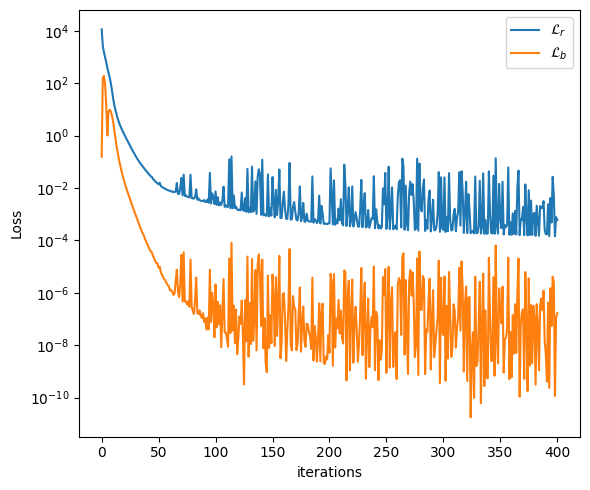

In [9]:
loss_bcs = model.loss_bcs_log
loss_res = model.loss_res_log

fig = plt.figure(figsize=(6,5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{b}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [10]:
nn = 1000
X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
u_star = u(X_star, a)
r_star = u_xx(X_star, a)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_r: {:.2e}'.format(error_r))

Relative L2 error_u: 2.17e-03
Relative L2 error_r: 3.81e-04


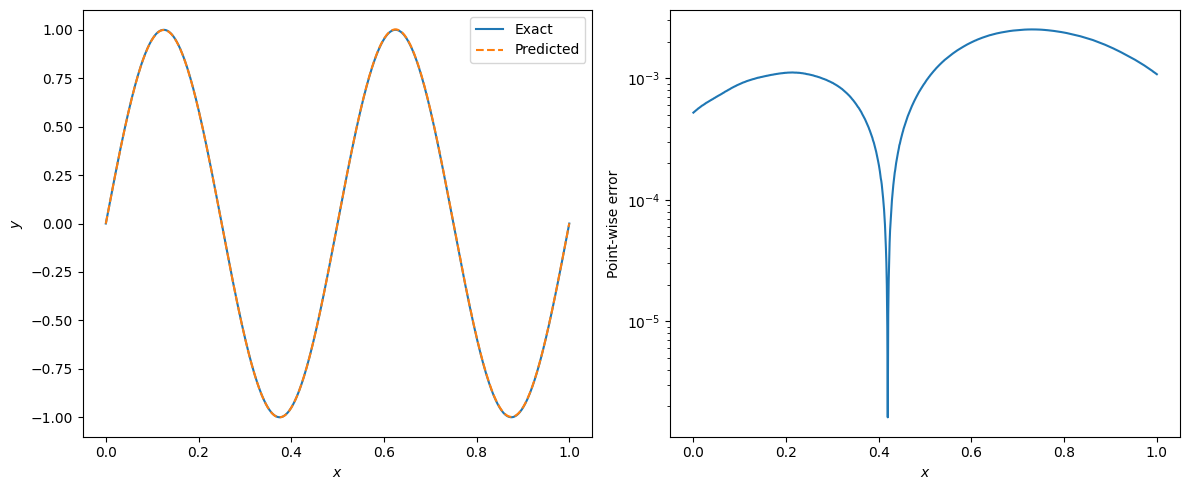

In [11]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(X_star, u_star, label='Exact')
plt.plot(X_star, u_pred, '--', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(X_star, np.abs(u_star - u_pred), label='Error')
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('Point-wise error')
plt.tight_layout()
plt.show()

**NTK Eigenvalues**

In [12]:
# Create empty lists for storing the eigenvalues of NTK
lambda_K_log = []
lambda_K_uu_log = []
lambda_K_ur_log = []
lambda_K_rr_log = []

# Restore the NTK
K_uu_list = model.K_uu_log
K_ur_list = model.K_ur_log
K_rr_list = model.K_rr_log
K_list = []

for k in range(len(K_uu_list)):
    K_uu = K_uu_list[k]
    K_ur = K_ur_list[k]
    K_rr = K_rr_list[k]

    K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1),
                        np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
    K_list.append(K)

    # Compute eigenvalues
    lambda_K, _ = np.linalg.eig(K)
    lambda_K_uu, _ = np.linalg.eig(K_uu)
    lambda_K_rr, _ = np.linalg.eig(K_rr)

    # Sort in descresing order
    lambda_K = np.sort(np.real(lambda_K))[::-1]
    lambda_K_uu = np.sort(np.real(lambda_K_uu))[::-1]
    lambda_K_rr = np.sort(np.real(lambda_K_rr))[::-1]

    # Store eigenvalues
    lambda_K_log.append(lambda_K)
    lambda_K_uu_log.append(lambda_K_uu)
    lambda_K_rr_log.append(lambda_K_rr)

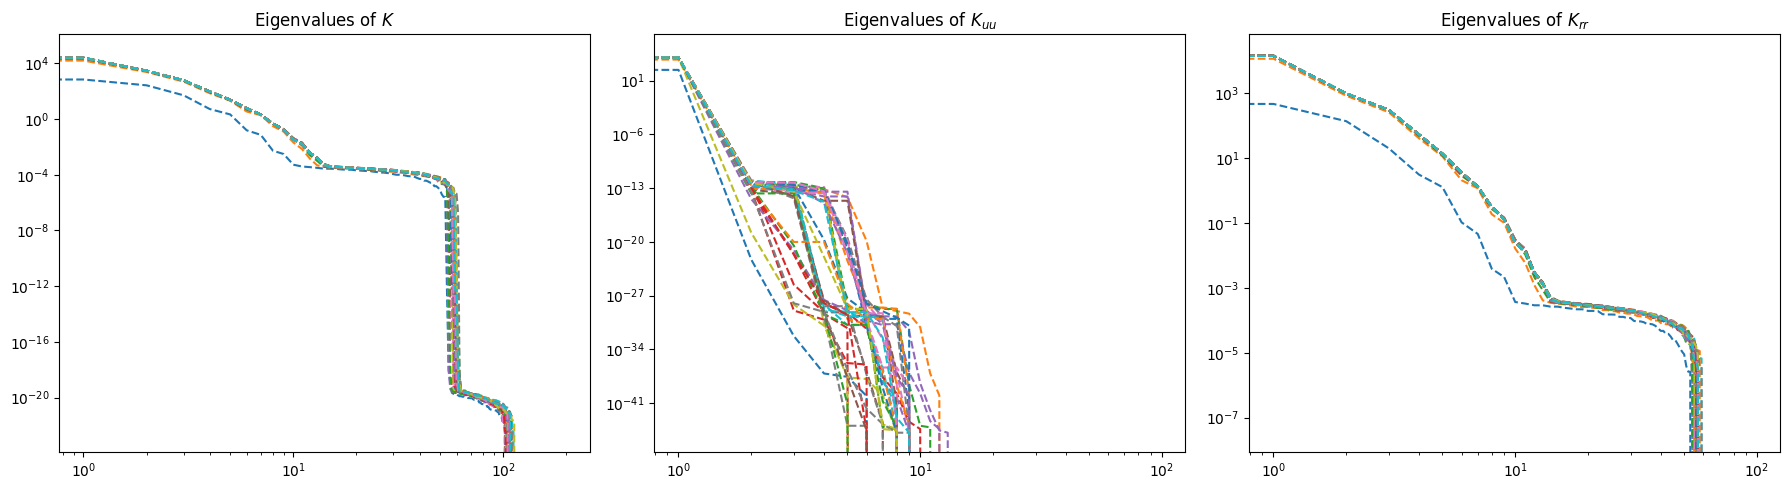

In [13]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}$')
plt.tight_layout()

plt.subplot(1,3,2)
for i in range(1, len(lambda_K_uu_log), 10):
    plt.plot(lambda_K_uu_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{uu}$')
plt.tight_layout()

plt.subplot(1,3,3)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_rr_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{rr}$')
plt.tight_layout()
plt.show()

**Change of NTK**

In [14]:
# Change of the NTK
NTK_change_list = []
K0 = K_list[0]
for K in K_list:
    diff = np.linalg.norm(K - K0) / np.linalg.norm(K0)
    NTK_change_list.append(diff)

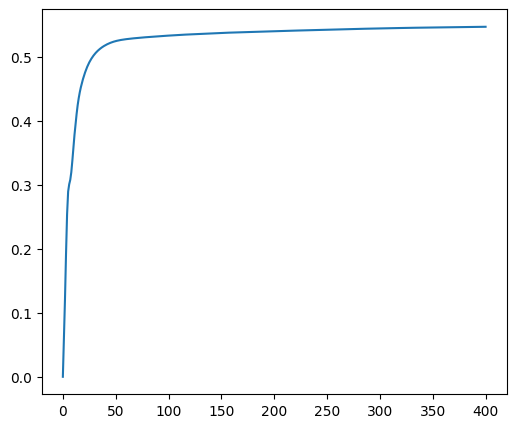

In [15]:
fig = plt.figure(figsize=(6,5))
plt.plot(NTK_change_list)


**Change of NN Params**

In [16]:
# Change of the weights and biases
def compute_weights_diff(weights_1, weights_2):
    weights = []
    N = len(weights_1)
    for k in range(N):
        weight = weights_1[k] - weights_2[k]
        weights.append(weight)
    return weights

def compute_weights_norm(weights, biases):
    norm = 0
    for w in weights:
        norm = norm + np.sum(np.square(w))
    for b in biases:
        norm = norm + np.sum(np.square(b))
    norm = np.sqrt(norm)
    return norm

# Restore the list weights and biases
weights_log = model.weights_log
biases_log = model.biases_log

weights_0 = weights_log[0]
biases_0 = biases_log[0]

# Norm of the weights at initialization
weights_init_norm = compute_weights_norm(weights_0, biases_0)

weights_change_list = []

N = len(weights_log)
for k in range(N):
    weights_diff = compute_weights_diff(weights_log[k], weights_log[0])
    biases_diff = compute_weights_diff(biases_log[k], biases_log[0])

    weights_diff_norm = compute_weights_norm(weights_diff, biases_diff)
    weights_change = weights_diff_norm / weights_init_norm
    weights_change_list.append(weights_change)

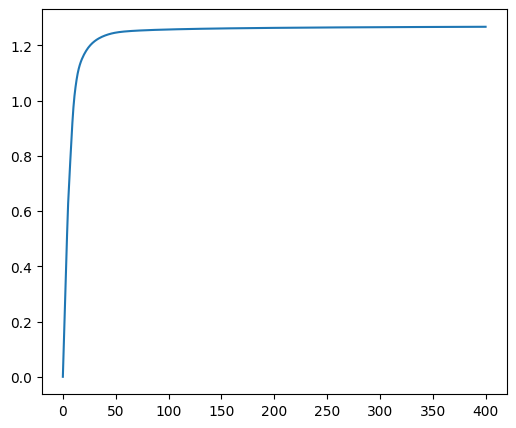

In [17]:
fig = plt.figure(figsize=(6,5))
plt.plot(weights_change_list)